In [113]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import json
import os

In [114]:
plt.style.use("ggplot")

In [119]:
def _load_data(file_name, repo, use_most_recent_file=True, parameter=None):
    if use_most_recent_file:
        try:
            file_name = sorted(glob.glob(f"./data/{repo}/{file_name}" + "*.json" ))[-1]
        except IndexError:
            raise ValueError(f"Data file {file_name} not found for {repo}.")
        assert os.path.exists(file_name), "no file found"
    else:
        file_name = "./data/{repo}/{file_name}.json"
        assert os.path.exists(file_name), "no file found"

    print(f"Loaded {repo} data from ", file_name)

    with open(file_name, "r") as f:
        data = json.load(f)

    # if not specified, load the first we encounter in the JSON
    if parameter is None:
        parameter = list(data[0]["params"].keys())[0]
    param_values = np.array([dat["params"][parameter] for dat in data])
    time_values = np.array([dat["time"] for dat in data])
    return param_values, time_values

def compare_plot(file_name, time_units="min", use_most_recent_file=True, parameter=None):
    
    def _plot(x, y, label=""):
        if time_units == "min": y /= 60.
        plt.plot(x, y, '.', label=label)
        m, b = np.polyfit(x, y, 1)
        plt.plot(x, m*x+b, '-', label=label)

    ssm_old = _load_data(file_name, "ssm_old", use_most_recent_file, parameter)
    ssm_jax = _load_data(file_name, "ssm_jax", use_most_recent_file, parameter)

    plt.figure(figsize=(8, 5))
    _plot(*ssm_old, label="SSM")
    _plot(*ssm_jax, label="SSM JAX")

    plt.xlabel(parameter)
    plt.ylabel(f"Time Elapsed ({time_units})")
    plt.legend()
    plt.show()

Loaded ssm_old data from  ./data/ssm_old/laplace_em.time_laplace_em.num_trials-20211019-151357.json
Loaded ssm_jax data from  ./data/ssm_jax/laplace_em.time_laplace_em.num_trials-20211019-150943.json


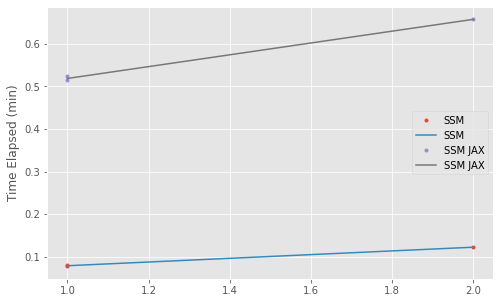

In [120]:
compare_plot("laplace_em")